In [30]:
import os
import sys
import pickle
import json
import torch
from tqdm import tqdm
sys.path.append('./modules')
from modules.utils import draw_countour
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from modules.dataset import prepare_ImageDataset
from modules.unet import UNet
from modules.validator import UNetValidator
from modules.utils import dice_coefficient

In [2]:
# Load configuraion file
with open('modules/config.json') as f:
    config = json.load(f)

### Functions definition

torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


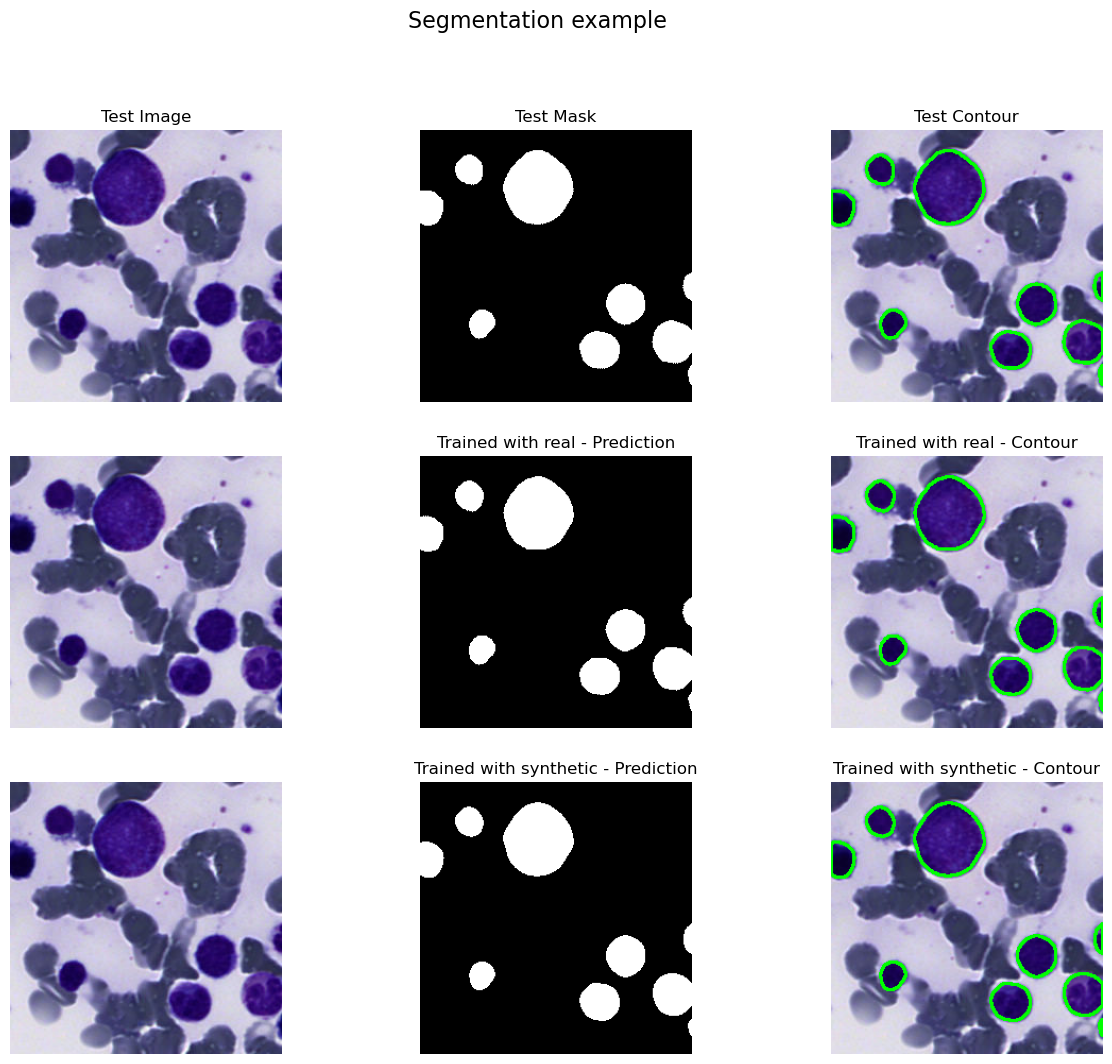

In [51]:
def plot_dice_history(history, title, save_folder, label):
    """ Plot dice coefficient history for the 'label' model
    
    Parameters
    ----------
    history : dict
        Dictionary containing the history of the model
    title : str 
        Title of the plot
    save_folder : str
        Folder where the plot will be saved
    label : str
        Label of the model: 'real' 'cond_gen' 'uncond_gen'
        
    Returns
    -------
    None
    """
    os.makedirs(save_folder, exist_ok=True)
    plt.plot(history['train_dice_coefficient'], label='train dice coefficient')
    plt.plot(history['val_dice_coefficient'], label='validation dice coefficient')
    plt.xlabel('epoch')
    plt.ylabel('dice coefficient')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(save_folder, f'{label}_dice_history.png'))
    plt.savefig(os.path.join(save_folder, f'{label}_dice_history.svg'))
    plt.close()


def compare_segmentation(model_1, model_2, img_filename, device):
    """ Compare segmentation of two models on the same image
    
    Parameters
    ----------
    model_1 : torch.nn.Module
        First model to be used for the segmentation
    model_2 : torch.nn.Module
        Second model to be used for the segmentation
    img_filename : str
        Filename of the image to be segmented
    device : torch.device
        Device to be used for the segmentation
        
    Returns
    -------
    None
    """
    full_img = plt.imread(img_filename)[...,:3]
    img = full_img[:, :256, :]
    mask = full_img[:, 256:, 0]
    torch_img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float().to(device)
    pred_1 = model_1.to(device)(torch_img)
    pred_1 = (pred_1 > 0.5).float()
    pred_2 = model_2.to(device)(torch_img)
    pred_2 = (pred_2 > 0.5).float()
    print(pred_1.shape, pred_2.shape)
    fig, ax = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Segmentation example', fontsize=16)

    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Test Image')
    ax[0, 0].axis('off')

    ax[0, 1].imshow(mask, cmap='gray')
    ax[0, 1].set_title('Test Mask')
    ax[0, 1].axis('off')

    ax[0, 2].imshow(draw_countour(img, mask), alpha=1.0)
    ax[0, 2].set_title('Test Contour')
    ax[0, 2].axis('off')

    ax[1, 0].imshow(img)
    ax[1, 0].axis('off')

    ax[1, 1].imshow(pred_1.cpu().squeeze(0).permute(1, 2, 0).detach().numpy(), cmap='gray')
    ax[1, 1].set_title('Trained with real - Prediction')
    ax[1, 1].axis('off')

    ax[1, 2].imshow(draw_countour(img, pred_1.cpu().squeeze().detach().numpy()), alpha=1.0)
    ax[1, 2].set_title('Trained with real - Contour')
    ax[1, 2].axis('off')

    ax[2, 0].imshow(img)
    ax[2, 0].axis('off')

    ax[2, 1].imshow(pred_2.cpu().squeeze(0).permute(1, 2, 0).detach().numpy(), cmap='gray')
    ax[2, 1].set_title('Trained with synthetic - Prediction')
    ax[2, 1].axis('off')

    ax[2, 2].imshow(draw_countour(img, pred_2.cpu().squeeze().detach().numpy()), alpha=1.0)
    ax[2, 2].set_title('Trained with synthetic - Contour')
    ax[2, 2].axis('off')
    
    plt.savefig('/mnt/local/work/filippo.schiazza2/Imgs4Paper/segmentation_example.png', bbox_inches='tight')
    plt.savefig('/mnt/local/work/filippo.schiazza2/Imgs4Paper/segmentation_example.svg', bbox_inches='tight')
    plt.show()
    plt.close()



filename = os.path.join(config['dataset']['test_dir'], '3301.png')
compare_segmentation(model_1, model_2, filename, device=config['device'])

def example_segmentation(model, dataset, save_folder, num_examples, title, device):
    """ Plot examples of segmentation for the model on the dataset

    Parameters
    ----------
    model : torch.nn.Module
        Model to be used for the segmentation
    dataset : torch.utils.data.Dataset
        Dataset to be used for the segmentation
    save_folder : str
        Folder where the examples will be saved
    num_examples : int
        Number of examples to be plotted
    title : str
        Title of the plot
    device : torch.device
        Device to be used for the segmentation

    Returns
    -------
    None
    """
    os.makedirs(save_folder, exist_ok=True)
    for i in range(num_examples):
        img, mask = dataset[i]
        img = img.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0)
        pred = model(img)
        pred = (pred > 0.5).float()
        plt.figure(figsize=(20, 4))
        plt.suptitle(title)
        plt.subplot(1, 5, 1)
        plt.imshow(img.squeeze().cpu().permute(1, 2, 0).numpy())
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 5, 2)
        plt.imshow(mask.squeeze().numpy(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(pred.cpu().squeeze().detach().numpy(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.imshow(draw_countour(img.cpu().squeeze().permute(1, 2, 0).numpy(), mask.squeeze().numpy()), alpha=1.0)
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 5, 5)
        plt.imshow(draw_countour(img.cpu().squeeze().permute(1, 2, 0).numpy(), pred.cpu().squeeze().detach().numpy()), alpha=1.0)
        plt.title('Prediction')
        plt.axis('off')
        #plt.savefig(os.path.join(save_folder, f'example_{i}.png'))
        #plt.savefig(os.path.join(save_folder, f'example_{i}.svg'))
        plt.show()
        plt.close()

### Load the datasets: Real, Conditionally Generated, Unconditionally Generated, Conditionally Generated with predicted masks and Test


In [3]:
# Real dataset used for training segmentation model
real_train_dataset, real_val_dataset, _, _ = prepare_ImageDataset(img_dir=config["dataset"]["img_dir"],
                                                                  batch_size=config["dataset"]["batch_size"],
                                                                  validation_split=config["dataset"]["validation_split"],
                                                                  transform=None,
                                                                  seed=123,
                                                                  fraction=config["dataset"]["fraction"])

# Synthetic dataset generated from masks used for training segmentation model
cond_gen_train_dataset, cond_gen_val_dataset, _, _ = prepare_ImageDataset(img_dir=config["dataset"]["cond_syn_img_dir"],
                                                                          batch_size=config["dataset"]["batch_size"],
                                                                          validation_split=config["dataset"]["validation_split"],
                                                                          transform=None,
                                                                          seed=123,
                                                                          fraction=config["dataset"]["fraction"])

# Synthetic dataset generated unconditionaly used for training segmentation model
uncond_gen_train_dataset, uncond_gen_val_dataset, _, _ = prepare_ImageDataset(img_dir=config["dataset"]["uncond_syn_img_dir"],
                                                                              batch_size=config["dataset"]["batch_size"],
                                                                              validation_split=config["dataset"]["validation_split"],
                                                                              transform=None,
                                                                              seed=123,
                                                                              fraction=config["dataset"]["fraction"])

# Synthetic dataset generated conditionally but with predicted masks used for training segmentation model
cond_pred_gen_train_dataset, cond_pred_gen_val_dataset, _, _ = prepare_ImageDataset(img_dir=config["dataset"]["cond_syn_img_dir_with_pred_mask"],
                                                                                    batch_size=config["dataset"]["batch_size"],
                                                                                    validation_split=config["dataset"]["validation_split"],
                                                                                    transform=None,
                                                                                    seed=123,
                                                                                    fraction=config["dataset"]["fraction"])

uncond4ch_gen_train_dataset, uncond4ch_gen_val_dataset, _, _ = prepare_ImageDataset(img_dir=config["dataset"]["4channels_img_dir"],
                                                                                    batch_size=config["dataset"]["batch_size"],
                                                                                    validation_split=config["dataset"]["validation_split"],
                                                                                    transform=None,
                                                                                    seed=123,
                                                                                    fraction=config["dataset"]["fraction"])

# Dataset of real patches used as test (never seen by all the models, both segmentation models and generative models)
real_test_dataset, _, _, _ = prepare_ImageDataset(img_dir=config["dataset"]["test_dir"],
                                                  batch_size=config["dataset"]["batch_size"],
                                                  validation_split=0,
                                                  transform=None,
                                                  seed=123,
                                                  fraction=1)

### Load the Models: trained on Real, on Conditionally Generated, on Unconditionally Generated

model_1 : segmentation model trained on real images

model_2 : segmentation model trained on conditionally generated images

model_3 : segmentation model trained on unconditionally generated images

model_4 : segmentation model trained on conditionally generated images where the masks are predicted as in the unconditional case

model_5 : segmentation model trained on unconditional generated images + masks

In [4]:
model_1 = UNet.load_model(config["eval_config"]["real_model_dir"])
model_2 = UNet.load_model(config["eval_config"]["cond_model_dir"])
model_3 = UNet.load_model(config["eval_config"]["uncond_model_dir"])
model_4 = UNet.load_model(config["eval_config"]["cond_with_pred_model_dir"])
model_5 = UNet.load_model(config["eval_config"]["uncond4ch_model_dir"])

history_1 = UNet.load_history(config["eval_config"]["real_model_dir"])
history_2 = UNet.load_history(config["eval_config"]["cond_model_dir"])
history_3 = UNet.load_history(config["eval_config"]["uncond_model_dir"])
history_4 = UNet.load_history(config["eval_config"]["cond_with_pred_model_dir"])
history_5 = UNet.load_history(config["eval_config"]["uncond4ch_model_dir"])

/home/PERSONALE/filippo.schiazza2/CellSegmentation/modules/unet.py:227: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_locati

### Plot examples

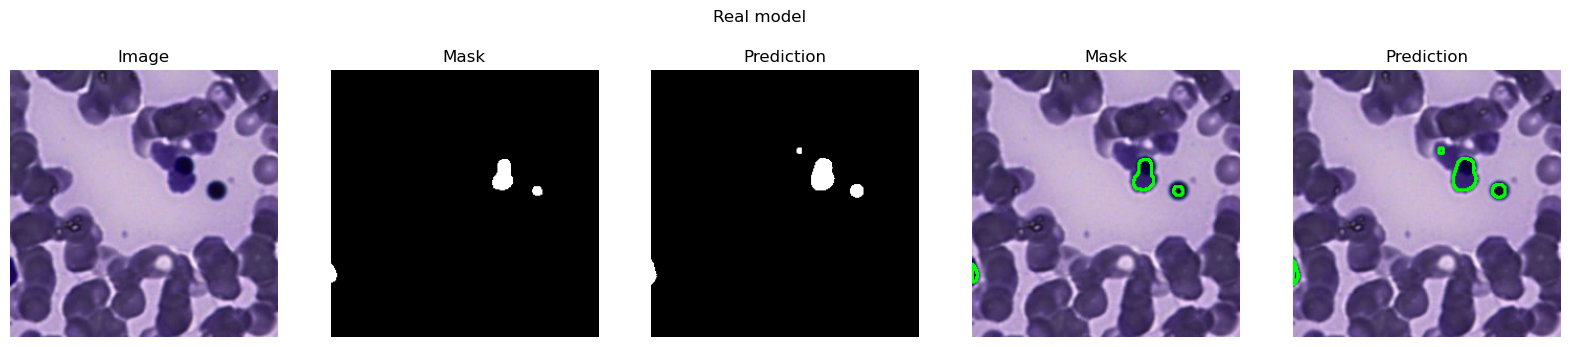

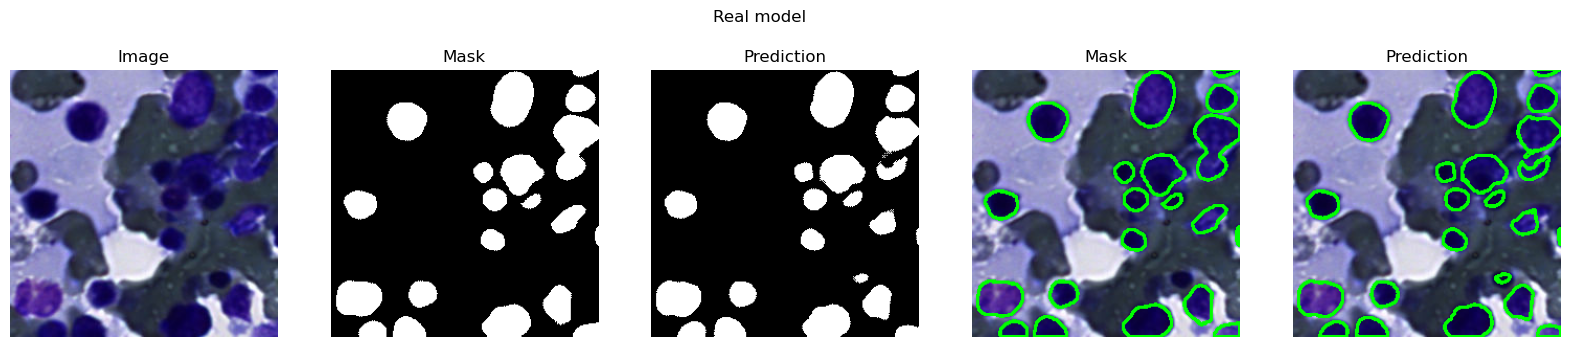

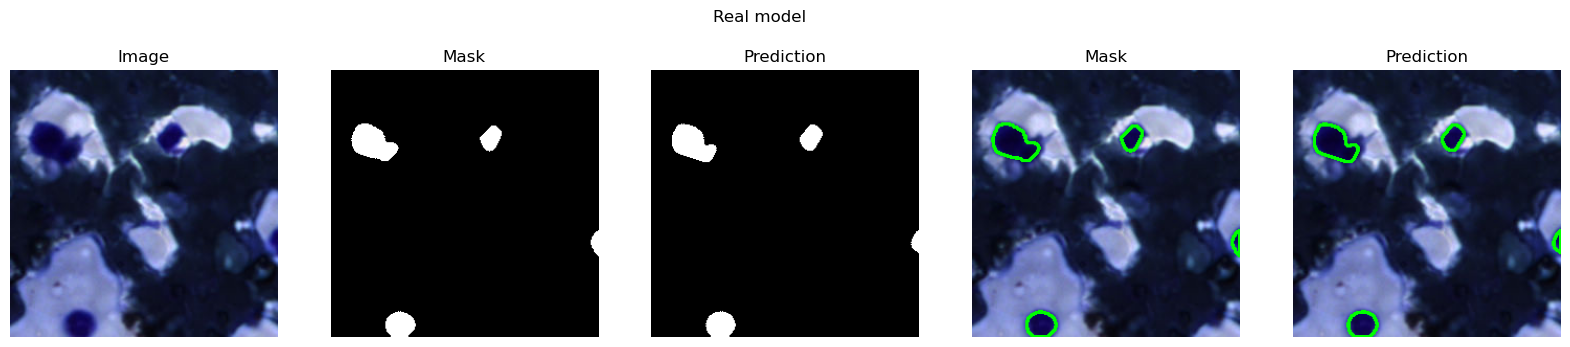

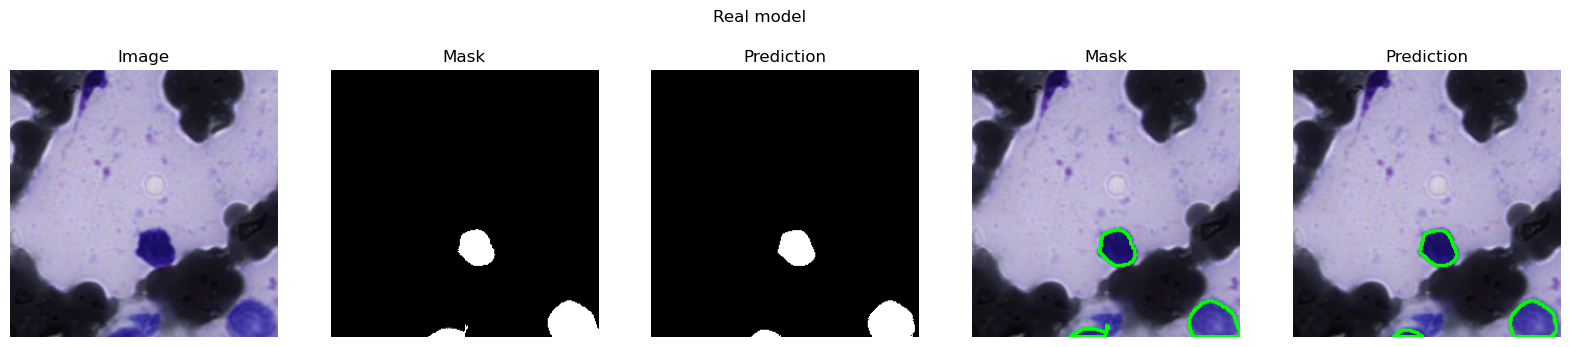

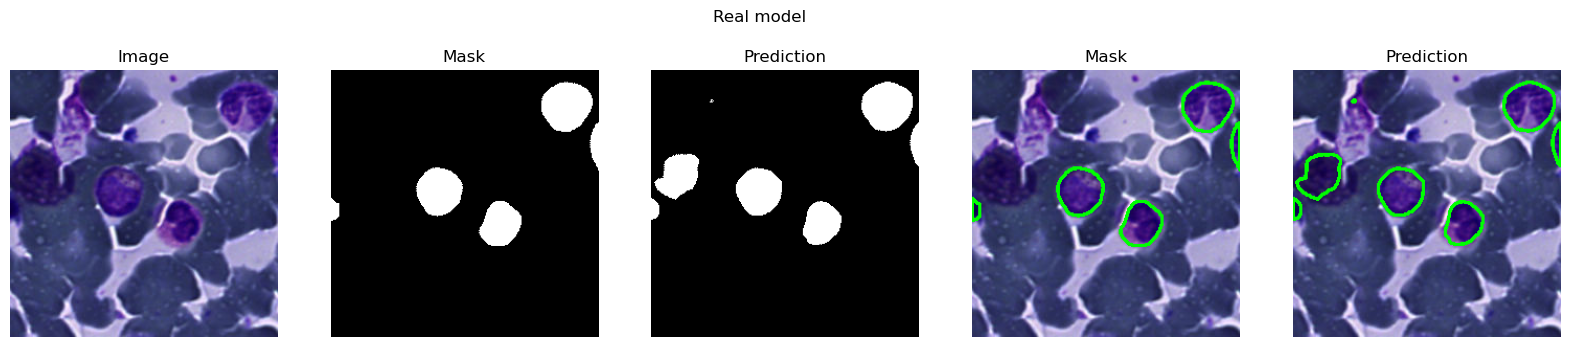

In [12]:
# plot segmentation examples for the real model
example_segmentation(model_1.to(config['device']), real_test_dataset, '.', 5, 'Real model', config["device"])

### Dice training and validation history

In [8]:
# Dice coefficient for the real model
save_folder = os.path.join(config["eval_config"]["save_results_dir"], 'dice_history')
plot_dice_history(history=history_1, 
                  title='Dice coefficient history: model trained on real images', 
                  save_folder=save_folder,
                  label='real')

# Dice coefficient for the cond_gen model
plot_dice_history(history=history_2, 
                  title='Dice coefficient history: model trained on conditional generated images',
                  save_folder=save_folder,
                  label='cond_gen')

# Dice coefficient for the uncond_gen model
plot_dice_history(history=history_3, 
                  title='Dice coefficient history: model trained on unconditionally generated images',
                  save_folder=save_folder,
                  label='uncond_gen')

# Dice coefficient for the cond_with_pred_gen model
plot_dice_history(history=history_4,
                  title='Dice coefficient history: model trained on conditional generated images with predicted masks',
                  save_folder=save_folder,
                  label='cond_with_pred_gen')

# Dice coefficient for the uncond4ch_gen model
plot_dice_history(history=history_5,
                  title='Dice coefficient history: model trained on unconditionally generated images and masks',
                  save_folder=save_folder,
                  label='uncond4ch_gen')



## Dice Results

In [5]:
# Validator for the real model
validator_1 = UNetValidator(model=model_1, device=config["device"]) 
# Validator for the cond_gen model
validator_2 = UNetValidator(model=model_2, device=config["device"])
# Validator for the uncond_gen model
validator_3 = UNetValidator(model=model_3, device=config["device"])
# Validator for the cond_with_pred_gen model
validator_4 = UNetValidator(model=model_4, device=config["device"])
# Validator for the uncond4ch_gen model
validator_5 = UNetValidator(model=model_5, device=config["device"])

In [10]:
NUM_SAMPLES = config["eval_config"]["num_samples_for_dice"]
# Dice with model trained on real images
dice_1_train = validator_1.validate(dataset=real_train_dataset, num_samples=NUM_SAMPLES)
dice_1_val = validator_1.validate(dataset=real_val_dataset, num_samples=NUM_SAMPLES)
dice_1_test = validator_1.validate(dataset=real_test_dataset, num_samples=NUM_SAMPLES)

# Dice with model trained on conditional generated images
dice_2_train = validator_2.validate(dataset=cond_gen_train_dataset, num_samples=NUM_SAMPLES)
dice_2_val = validator_2.validate(dataset=cond_gen_val_dataset, num_samples=NUM_SAMPLES)
dice_2_test = validator_2.validate(dataset=real_test_dataset, num_samples=NUM_SAMPLES)

# Dice with model trained on unconditionally generated images
dice_3_train = validator_3.validate(dataset=uncond_gen_train_dataset, num_samples=NUM_SAMPLES)
dice_3_val = validator_3.validate(dataset=uncond_gen_val_dataset, num_samples=NUM_SAMPLES)
dice_3_test = validator_3.validate(dataset=real_test_dataset, num_samples=NUM_SAMPLES)

# Dice with model trained on conditional generated images with predicted masks
dice_4_train = validator_4.validate(dataset=cond_pred_gen_train_dataset, num_samples=NUM_SAMPLES)
dice_4_val = validator_4.validate(dataset=cond_pred_gen_val_dataset, num_samples=NUM_SAMPLES)
dice_4_test = validator_4.validate(dataset=real_test_dataset, num_samples=NUM_SAMPLES)

# Dice with model trained on unconditionally generated images and masks
dice_5_train = validator_5.validate(dataset=uncond4ch_gen_train_dataset, num_samples=NUM_SAMPLES)
dice_5_val = validator_5.validate(dataset=uncond4ch_gen_val_dataset, num_samples=NUM_SAMPLES)
dice_5_test = validator_5.validate(dataset=real_test_dataset, num_samples=NUM_SAMPLES)




100%|██████████| 5000/5000 [06:00<00:00, 13.87it/s]


In [11]:
# Create a dataframe with the results
result_dict = {'Real-Train': dice_1_train,
               'Real-Val': dice_1_val,
               'Real-Test': dice_1_test,
               'Cond-Train': dice_2_train,
               'Cond-Val': dice_2_val,
               'Cond-Test': dice_2_test,
               'Uncond-Train': dice_3_train,
               'Uncond-Val': dice_3_val,
               'Uncond-Test': dice_3_test,
               'Cond_with_pred-Train': dice_4_train,
               'Cond_with_pred-Val': dice_4_val,
               'Cond_with_pred-Test': dice_4_test,
               'Uncond4ch-Train': dice_5_train,
               'Uncond4ch-Val': dice_5_val,
               'Uncond4ch-Test': dice_5_test
                }
save_filename = os.path.join(config["eval_config"]["save_results_dir"], 'dice_results.pkl')
with open(save_filename, 'wb') as f:
    pickle.dump(result_dict, f)

# For each list in the dictionary, if the len in not 5000, fill with NaN
max_len = max([len(v) for v in result_dict.values()])
for k, v in result_dict.items():
    if len(v) < max_len:
        result_dict[k] = v + [np.nan] * (max_len - len(v))

df = pd.DataFrame(result_dict)
df.to_csv(os.path.join(config["eval_config"]["save_results_dir"], 'dice_results.csv'))

### Load dice results and summarize them

In [12]:
dice_df = pd.read_csv(os.path.join(config["eval_config"]["save_results_dir"], 'dice_results.csv'), index_col=0)

In [13]:
# take the median, mean and std of the dice coefficients. Make a dataframe with the results

## MEDIAN
median_df = dice_df.median()
q1 = dice_df.quantile(0.25)
q3 = dice_df.quantile(0.75)
iqr = q3 - q1
n = len(dice_df)
delta_median = 1.57 * iqr / np.sqrt(n)

## MEAN
mean_df = dice_df.mean()
std_df = dice_df.std()
delta_mean = std_df / np.sqrt(n)

num_digits = 4


result_dict = {'Real': [f"{median_df['Real-Train']:.{num_digits}f} ± {delta_median['Real-Train']:.{num_digits}f}",
                        f"{median_df['Real-Val']:.{num_digits}f} ± {delta_median['Real-Val']:.{num_digits}f}",
                        f"{median_df['Real-Test']:.{num_digits}f} ± {delta_median['Real-Test']:.{num_digits}f}",
                        f"{mean_df['Real-Train']:.{num_digits}f} ± {delta_mean['Real-Train']:.{num_digits}f}",
                        f"{mean_df['Real-Val']:.{num_digits}f} ± {delta_mean['Real-Val']:.{num_digits}f}",
                        f"{mean_df['Real-Test']:.{num_digits}f} ± {delta_mean['Real-Test']:.{num_digits}f}"],
               'Cond-Gen': [f"{median_df['Cond-Train']:.{num_digits}f} ± {delta_median['Cond-Train']:.{num_digits}f}",
                            f"{median_df['Cond-Val']:.{num_digits}f} ± {delta_median['Cond-Val']:.{num_digits}f}",
                            f"{median_df['Cond-Test']:.{num_digits}f} ± {delta_median['Cond-Test']:.{num_digits}f}",
                            f"{mean_df['Cond-Train']:.{num_digits}f} ± {delta_mean['Cond-Train']:.{num_digits}f}",
                            f"{mean_df['Cond-Val']:.{num_digits}f} ± {delta_mean['Cond-Val']:.{num_digits}f}",
                            f"{mean_df['Cond-Test']:.{num_digits}f} ± {delta_mean['Cond-Test']:.{num_digits}f}"],
               'Uncond-Gen': [f"{median_df['Uncond-Train']:.{num_digits}f} ± {delta_median['Uncond-Train']:.{num_digits}f}",
                              f"{median_df['Uncond-Val']:.{num_digits}f} ± {delta_median['Uncond-Val']:.{num_digits}f}",
                              f"{median_df['Uncond-Test']:.{num_digits}f} ± {delta_median['Uncond-Test']:.{num_digits}f}",
                              f"{mean_df['Uncond-Train']:.{num_digits}f} ± {delta_mean['Uncond-Train']:.{num_digits}f}",
                              f"{mean_df['Uncond-Val']:.{num_digits}f} ± {delta_mean['Uncond-Val']:.{num_digits}f}",
                              f"{mean_df['Uncond-Test']:.{num_digits}f} ± {delta_mean['Uncond-Test']:.{num_digits}f}"],
                'Cond_with_pred-Gen': [f"{median_df['Cond_with_pred-Train']:.{num_digits}f} ± {delta_median['Cond_with_pred-Train']:.{num_digits}f}",
                                       f"{median_df['Cond_with_pred-Val']:.{num_digits}f} ± {delta_median['Cond_with_pred-Val']:.{num_digits}f}",
                                       f"{median_df['Cond_with_pred-Test']:.{num_digits}f} ± {delta_median['Cond_with_pred-Test']:.{num_digits}f}",
                                       f"{mean_df['Cond_with_pred-Train']:.{num_digits}f} ± {delta_mean['Cond_with_pred-Train']:.{num_digits}f}",
                                       f"{mean_df['Cond_with_pred-Val']:.{num_digits}f} ± {delta_mean['Cond_with_pred-Val']:.{num_digits}f}",
                                       f"{mean_df['Cond_with_pred-Test']:.{num_digits}f} ± {delta_mean['Cond_with_pred-Test']:.{num_digits}f}"],
                'Uncond4ch-Gen': [f"{median_df['Uncond4ch-Train']:.{num_digits}f} ± {delta_median['Uncond4ch-Train']:.{num_digits}f}",
                                  f"{median_df['Uncond4ch-Val']:.{num_digits}f} ± {delta_median['Uncond4ch-Val']:.{num_digits}f}",
                                  f"{median_df['Uncond4ch-Test']:.{num_digits}f} ± {delta_median['Uncond4ch-Test']:.{num_digits}f}",
                                  f"{mean_df['Uncond4ch-Train']:.{num_digits}f} ± {delta_mean['Uncond4ch-Train']:.{num_digits}f}",
                                  f"{mean_df['Uncond4ch-Val']:.{num_digits}f} ± {delta_mean['Uncond4ch-Val']:.{num_digits}f}",
                                  f"{mean_df['Uncond4ch-Test']:.{num_digits}f} ± {delta_mean['Uncond4ch-Test']:.{num_digits}f}"]
                    }

summary_df = pd.DataFrame(result_dict, index=['Median-Train', 'Median-Val', 'Median-Test',
                                                'Mean-Train', 'Mean-Val', 'Mean-Test'])

In [14]:
summary_df

Real         Cond-Gen       Uncond-Gen  \
Median-Train  0.9931 ± 0.0001  0.9951 ± 0.0001  0.9943 ± 0.0002   
Median-Val    0.9559 ± 0.0015  0.9545 ± 0.0014  0.9574 ± 0.0025   
Median-Test   0.9527 ± 0.0016  0.9327 ± 0.0027  0.9490 ± 0.0019   
Mean-Train    0.9918 ± 0.0001  0.9932 ± 0.0003  0.9618 ± 0.0023   
Mean-Val      0.9103 ± 0.0018  0.8950 ± 0.0024  0.8626 ± 0.0033   
Mean-Test     0.9200 ± 0.0013  0.8852 ± 0.0017  0.9128 ± 0.0014   

             Cond_with_pred-Gen    Uncond4ch-Gen  
Median-Train    0.9965 ± 0.0001  0.9826 ± 0.0002  
Median-Val      0.9767 ± 0.0009  0.9337 ± 0.0016  
Median-Test     0.9483 ± 0.0020  0.9377 ± 0.0019  
Mean-Train      0.9853 ± 0.0013  0.9258 ± 0.0032  
Mean-Val        0.9240 ± 0.0022  0.8663 ± 0.0030  
Mean-Test       0.9120 ± 0.0013  0.9025 ± 0.0014

In [ ]:
# make a boxplot with matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot([dice_df['Real-Train'], dice_df['Real-Val'], dice_df['Real-Test'],
                dice_df['Cond-Train'], dice_df['Cond-Val'], dice_df['Cond-Test'],
                dice_df['Uncond-Train'], dice_df['Uncond-Val'], dice_df['Uncond-Test']],
                dice_df['Cond_with_pred-Train'], dice_df['Cond_with_pred-Val'], dice_df['Cond_with_pred-Test'],
                patch_artist=True,
                showfliers=True,
                notch=True)
plt.xticks(range(1, 13), ['Real-Train', 'Real-Val', 'Real-Test',
                          'Cond-Train', 'Cond-Val', 'Cond-Test',
                          'Uncond-Train', 'Uncond-Val', 'Uncond-Test',
                          'Cond_with_pred-Train', 'Cond_with_pred-Val', 'Cond_with_pred-Test'], rotation=45)

plt.title('Dice Coefficients for different combinations model - dataset')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(config["eval_config"]["save_results_dir"], 'dice_boxplot.png'))



### Where does our model fail?

In [40]:
dic = {}
for i in tqdm(range(1000)):
    img, mask = real_test_dataset[i]
    img = img.unsqueeze(0).to(config['device'])
    pred_1 = model_2(img).squeeze().detach().cpu()
    pred_1 = (pred_1 > 0.5).to(dtype=torch.uint8)
    pred_2 = model_5(img).squeeze().detach().cpu()
    pred_2 = (pred_2 > 0.5).to(dtype=torch.uint8)
    dice_1 = dice_coefficient(mask, pred_1)
    dice_2 = dice_coefficient(mask, pred_2)
    dic[i] = (dice_1, dice_2)
    

100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s]


In [42]:
order_dic = sorted(dic.items(), key=lambda x: x[1][1] -x[1][0], reverse=True)
order_idxs = [i[0] for i in order_dic][:10]

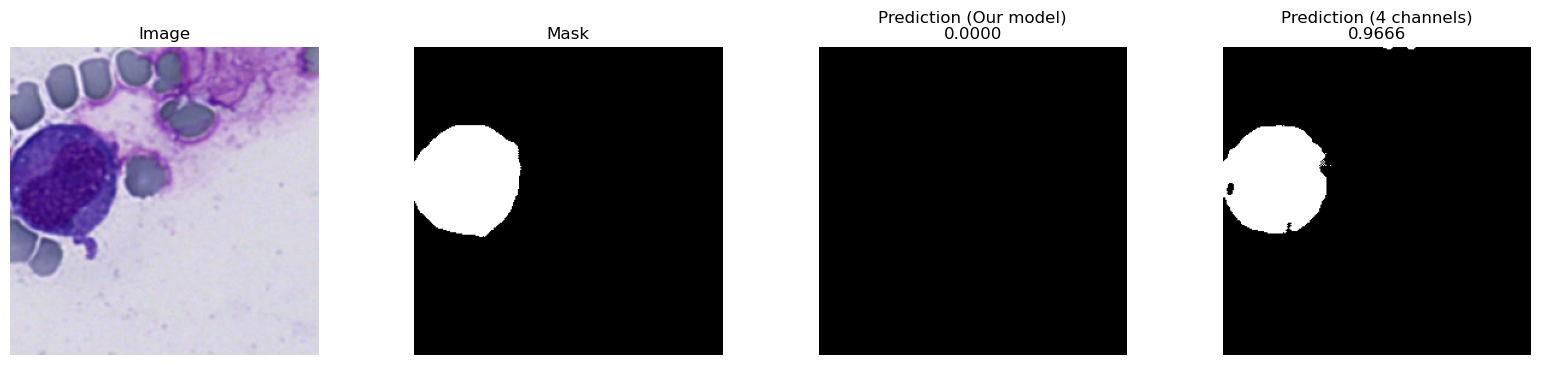

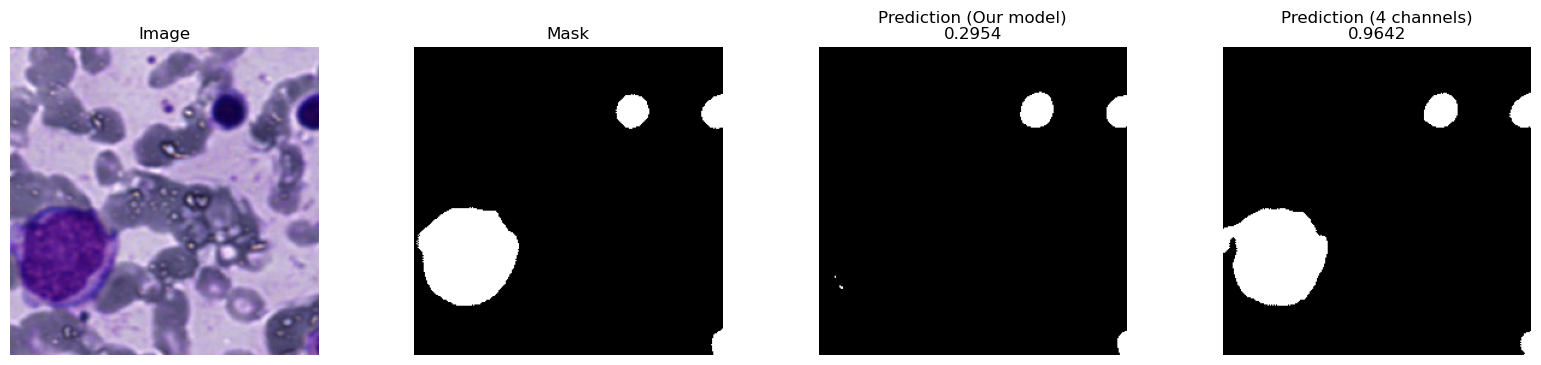

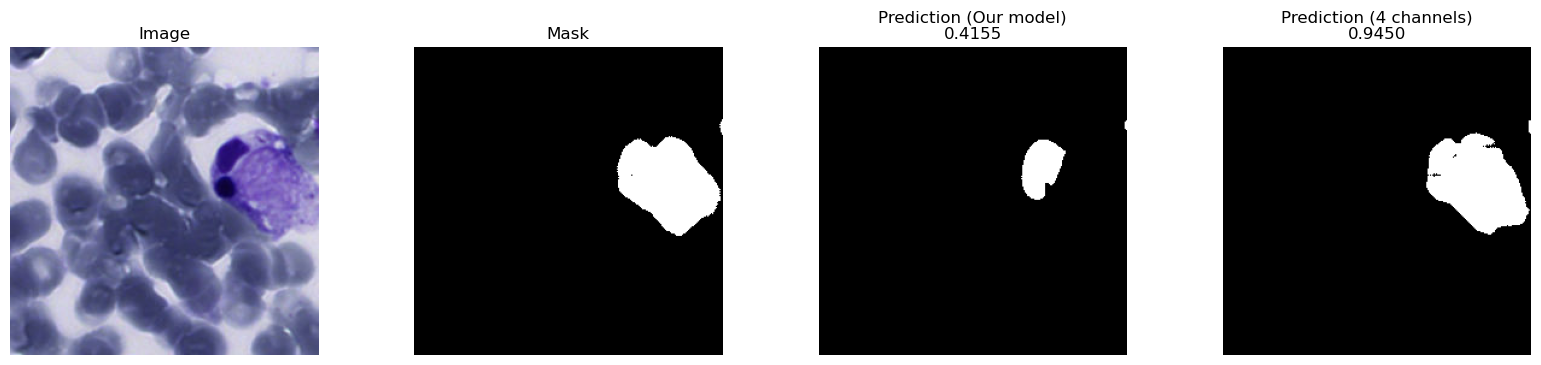

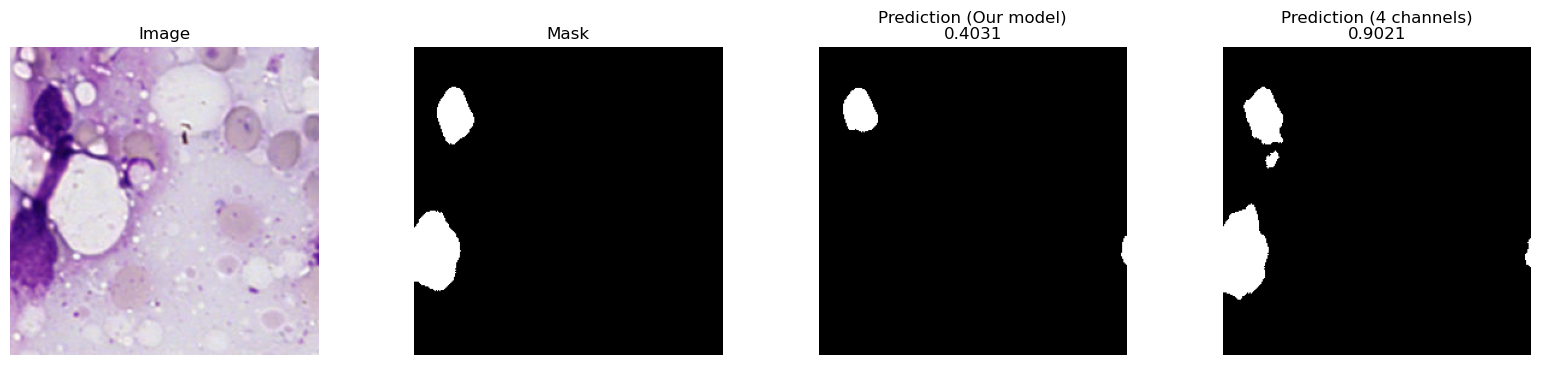

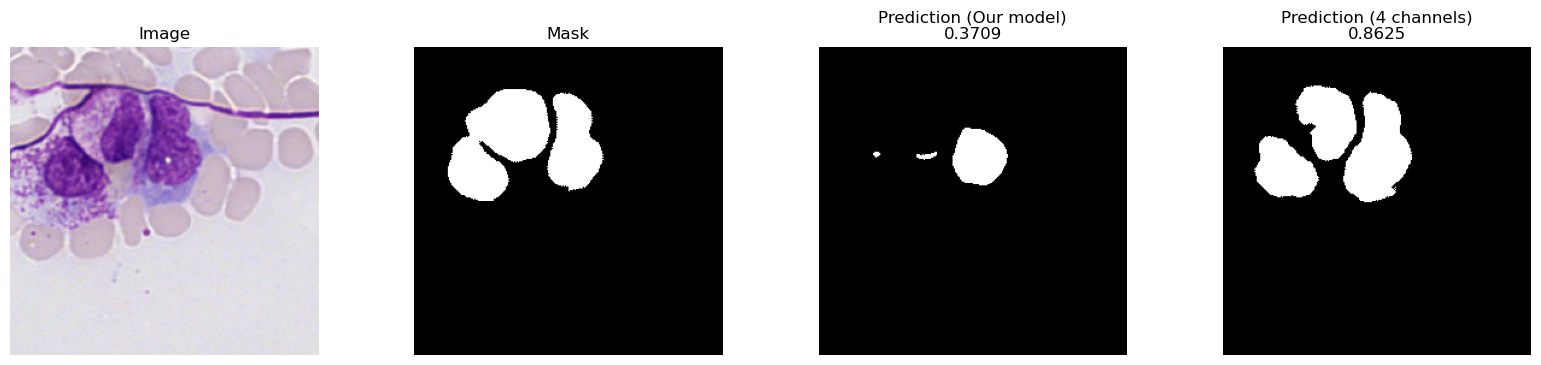

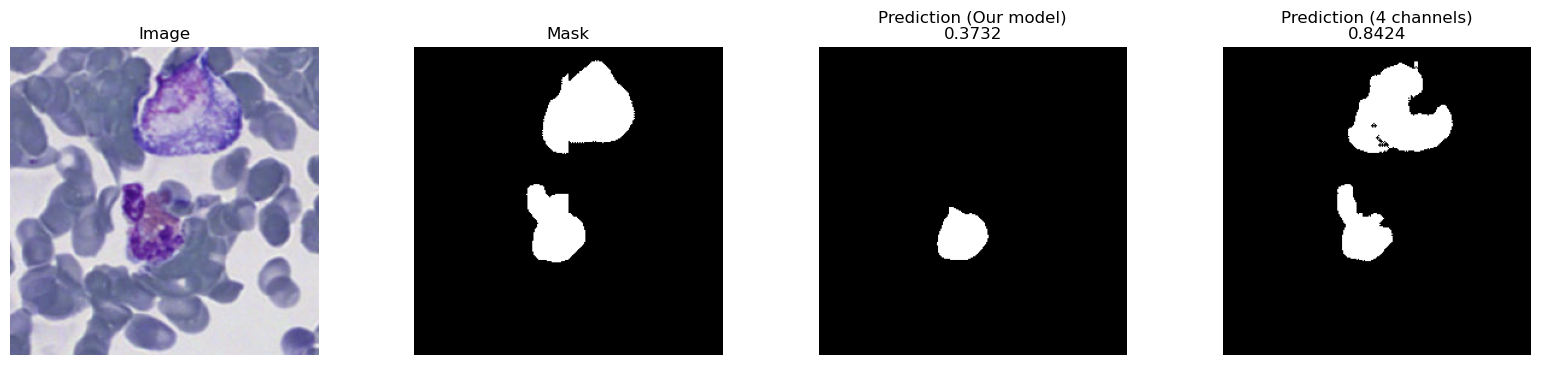

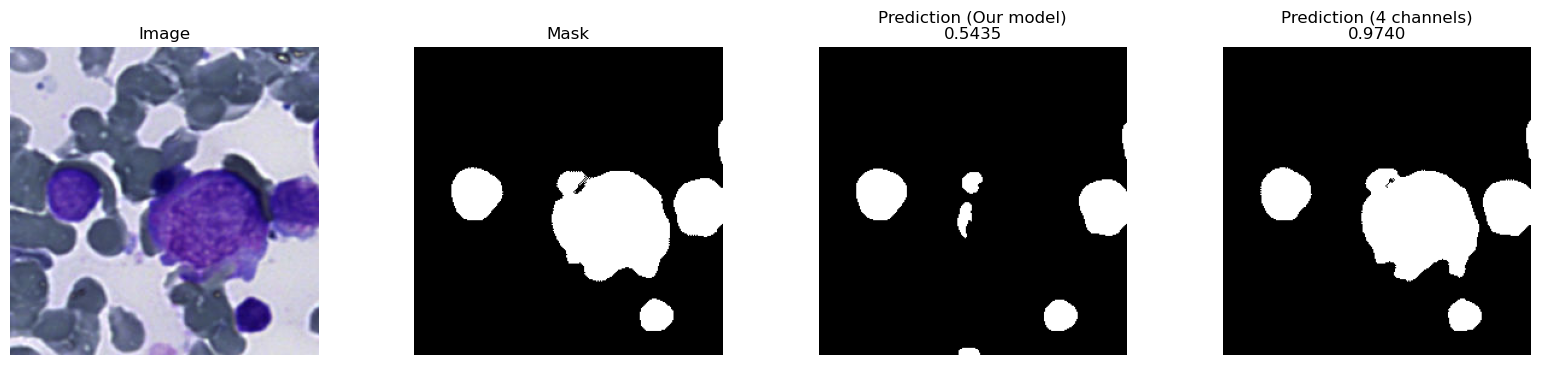

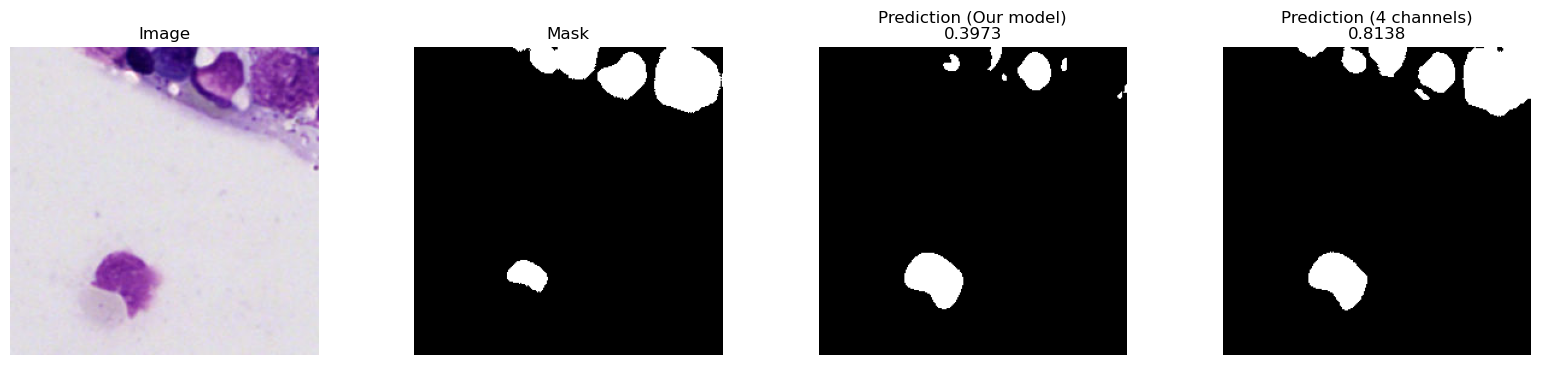

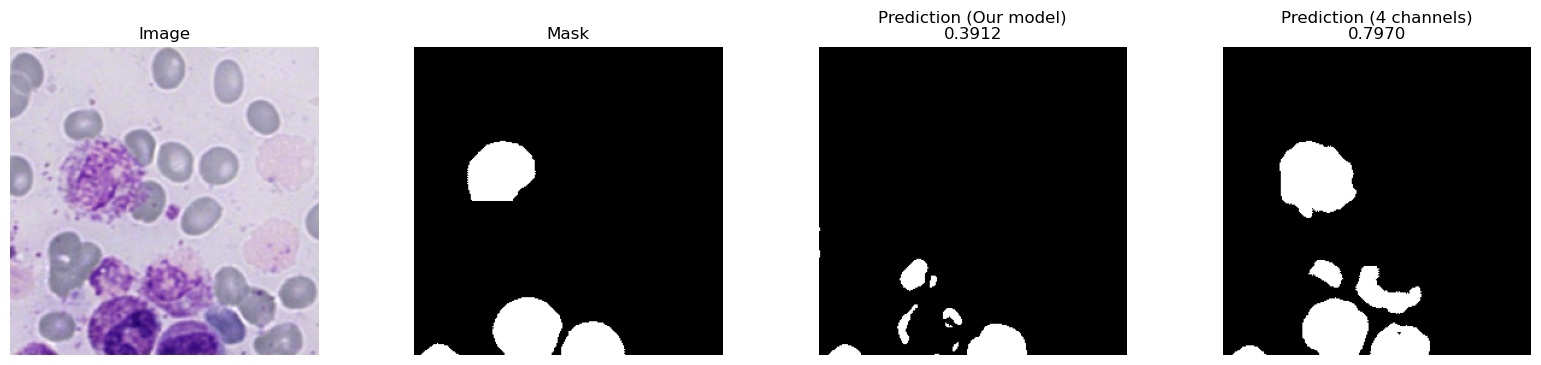

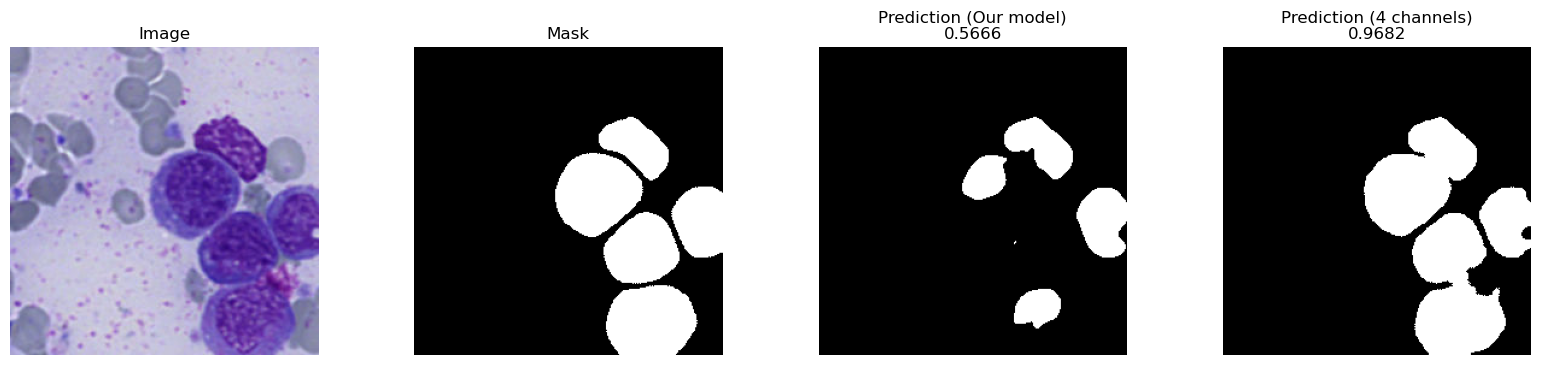

In [46]:
for n, i in enumerate(order_idxs):
    img, mask = real_test_dataset[i]
    img = img.unsqueeze(0).to(config['device'])
    pred_1 = model_2(img).squeeze().detach().cpu()
    pred_1 = (pred_1 > 0.5).to(dtype=torch.uint8)
    pred_2 = model_5(img).squeeze().detach().cpu()
    pred_2 = (pred_2 > 0.5).to(dtype=torch.uint8)
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img.squeeze().cpu().permute(1, 2, 0).numpy())
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(pred_1.cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'Prediction (Our model)\n{order_dic[n][1][0]:.4f}')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(pred_2.cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'Prediction (4 channels)\n{order_dic[n][1][1]:.4f}')
    plt.axis('off')
    plt.show()
